# Entrenamiento con Detectron2

## Configuración Previa

In [2]:
# Instalación de Detectron2 y sus dependencias

!python -m pip install pyyaml==5.1

!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Using cached pyyaml-5.1-cp310-cp310-linux_x86_64.whl
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0.2
    Uninstalling PyYAML-6.0.2:
      Successfully uninstalled PyYAML-6.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-events 0.12.0 requires pyyaml>=5.3, but you have pyyaml 5.1 which is incompatible.
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-ff_1wbh3
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-ff_1wbh3
  Resolved https://github.com/facebookresearch/detectron2.git to commit 18f69583391e5040043ca4f4bebd2c60f0ebfde0
  Preparing metadata (setup.py) ... done


In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Jun__8_16:49:14_PDT_2022
Cuda compilation tools, release 11.7, V11.7.99
Build cuda_11.7.r11.7/compiler.31442593_0
torch:  2.0 ; cuda:  2.0.1
detectron2: 0.6


In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow   # solo para Google Colab
import sys, os, distutils.core
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from matplotlib import pyplot as plt
from detectron2.data.datasets import register_coco_instances

In [5]:
# Conectar con Google Drive. Recomendado para la ejecución en Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
base_path_dir = '/mnt/Data1/MSLesSeg-Dataset' # modificar la ruta a la que contiene las imágenes
path_dir_model = "/home/albacano/TFM-Scripts/Detectron2_models"
path_dir_train = base_path_dir + "/outputDivided_trainFLAIR"
path_dir_val = base_path_dir + "/outputDivided_valFLAIR"

## Entrenamiento Detectron2

In [4]:
from detectron2.data.datasets import register_coco_instances
# Establecer las rutas de los conjuntos de entrenamiento y validación y sus respectivos archivos .json

# registrar de forma automatica las diferentes rutas para cada conjunto de kcrossvalidation

register_coco_instances("my_dataset_train", {}, f"{path_dir_train}/annotations.json", f"{path_dir_train}")
register_coco_instances("my_dataset_val", {}, f"{path_dir_val}/annotations.json", f"{path_dir_val}")

In [5]:
# Extracción de los metadatos para los conjuntos de entrenamiento y validación. Se utilizarán para visualizar, inferir y evaluar el modelo
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")
val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

[07/14 20:20:02 d2.data.datasets.coco]: Loaded 13286 images in COCO format from /mnt/Data1/MSLesSeg-Dataset/outputDivided_trainFLAIR/annotations.json
[07/14 20:20:02 d2.data.datasets.coco]: Loaded 3458 images in COCO format from /mnt/Data1/MSLesSeg-Dataset/outputDivided_valFLAIR/annotations.json


In [10]:
register_coco_instances("my_dataset_train1CV", {}, f"{path_dir}/1CrossVal/trainImages/trainMascaras-MSLesSeg.json", f"{path_dir}/1CrossVal/trainImages")
register_coco_instances("my_dataset_val1CV", {}, f"{path_dir}/1CrossVal/valImages/valMascaras-MSLesSeg.json", f"{path_dir}/1CrossVal/valImages")

train_metadata1CV = MetadataCatalog.get("my_dataset_train1CV")
train_dataset_dicts1CV = DatasetCatalog.get("my_dataset_train1CV")
val_metadata1CV = MetadataCatalog.get("my_dataset_val1CV")
val_dataset_dicts1CV = DatasetCatalog.get("my_dataset_val1CV")

[05/29 18:50:35 d2.data.datasets.coco]: Loaded 13286 images in COCO format from /content/drive/MyDrive/TFM/MSLesSeg-Dataset/RGBkCV/1CrossVal/trainImages/trainMascaras-MSLesSeg.json
[05/29 18:50:35 d2.data.datasets.coco]: Loaded 3458 images in COCO format from /content/drive/MyDrive/TFM/MSLesSeg-Dataset/RGBkCV/1CrossVal/valImages/valMascaras-MSLesSeg.json


In [12]:
register_coco_instances("my_dataset_train2CV", {}, f"{path_dir}/2CrossVal/trainImages/trainMascaras-MSLesSeg.json", f"{path_dir}/2CrossVal/trainImages")
register_coco_instances("my_dataset_val2CV", {}, f"{path_dir}/2CrossVal/valImages/valMascaras-MSLesSeg.json", f"{path_dir}/2CrossVal/valImages")

train_metadata2CV = MetadataCatalog.get("my_dataset_train2CV")
train_dataset_dicts2CV = DatasetCatalog.get("my_dataset_train2CV")
val_metadata2CV = MetadataCatalog.get("my_dataset_val2CV")
val_dataset_dicts2CV = DatasetCatalog.get("my_dataset_val2CV")

[05/29 18:51:39 d2.data.datasets.coco]: Loading /content/drive/MyDrive/TFM/MSLesSeg-Dataset/RGBkCV/2CrossVal/trainImages/trainMascaras-MSLesSeg.json takes 44.62 seconds.
[05/29 18:51:39 d2.data.datasets.coco]: Loaded 13286 images in COCO format from /content/drive/MyDrive/TFM/MSLesSeg-Dataset/RGBkCV/2CrossVal/trainImages/trainMascaras-MSLesSeg.json
[05/29 18:51:52 d2.data.datasets.coco]: Loading /content/drive/MyDrive/TFM/MSLesSeg-Dataset/RGBkCV/2CrossVal/valImages/valMascaras-MSLesSeg.json takes 12.82 seconds.
[05/29 18:51:52 d2.data.datasets.coco]: Loaded 3458 images in COCO format from /content/drive/MyDrive/TFM/MSLesSeg-Dataset/RGBkCV/2CrossVal/valImages/valMascaras-MSLesSeg.json


## Training

In [10]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = f"{path_dir_model}/2000epochsFLAIR"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Descarga del modelo troncal Mask R-CNN con ResNet50 y FPN
cfg.SOLVER.IMS_PER_BATCH = 2  # El batch es pequeño dada la dimensión de nuestro conjunto de datos
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 2000    # 6000 iteraciones han sido las óptimas para el proyecto
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Tenemos tan solo la clase Lesion, no se tiene en cuenta el fondo de la imagen

In [1]:
import torch
print(torch.version.cuda)
print(torch.cuda.is_available())

11.7
True


In [ ]:
PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python

NameError: name 'python' is not defined

In [9]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) # Se crea un objeto Trainer con la configuración
trainer.resume_or_load(resume=True) # cambiar a True para utilizar el último checkpoint y reanudar el entrenamiento

[07/09 21:20:36 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:03, 45.6MB/s]                               
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due 

In [10]:
trainer.train()

[07/09 21:20:54 d2.engine.train_loop]: Starting training from iteration 0
ERROR [07/09 21:20:54 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/home/albacano/.conda/envs/det2Env/lib/python3.10/site-packages/detectron2/engine/train_loop.py", line 155, in train
    self.run_step()
  File "/home/albacano/.conda/envs/det2Env/lib/python3.10/site-packages/detectron2/engine/defaults.py", line 530, in run_step
    self._trainer.run_step()
  File "/home/albacano/.conda/envs/det2Env/lib/python3.10/site-packages/detectron2/engine/train_loop.py", line 297, in run_step
    data = next(self._data_loader_iter)
  File "/home/albacano/.conda/envs/det2Env/lib/python3.10/site-packages/detectron2/data/common.py", line 329, in __iter__
    for d in self.dataset:
  File "/home/albacano/.conda/envs/det2Env/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 633, in __next__
    data = self._next_data()
  File "/home/albacano/.conda/envs/det2Env/lib

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/albacano/.conda/envs/det2Env/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/albacano/.conda/envs/det2Env/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 32, in fetch
    data.append(next(self.dataset_iter))
  File "/home/albacano/.conda/envs/det2Env/lib/python3.10/site-packages/detectron2/data/common.py", line 296, in __iter__
    yield self.dataset[idx]
  File "/home/albacano/.conda/envs/det2Env/lib/python3.10/site-packages/detectron2/data/common.py", line 125, in __getitem__
    data = self._map_func(self._dataset[cur_idx])
  File "/home/albacano/.conda/envs/det2Env/lib/python3.10/site-packages/detectron2/utils/serialize.py", line 26, in __call__
    return self._obj(*args, **kwargs)
  File "/home/albacano/.conda/envs/det2Env/lib/python3.10/site-packages/detectron2/data/dataset_mapper.py", line 154, in __call__
    image = utils.read_image(dataset_dict["file_name"], format=self.image_format)
  File "/home/albacano/.conda/envs/det2Env/lib/python3.10/site-packages/detectron2/data/detection_utils.py", line 180, in read_image
    with PathManager.open(file_name, "rb") as f:
  File "/home/albacano/.conda/envs/det2Env/lib/python3.10/site-packages/iopath/common/file_io.py", line 1012, in open
    bret = handler._open(path, mode, buffering=buffering, **kwargs)  # type: ignore
  File "/home/albacano/.conda/envs/det2Env/lib/python3.10/site-packages/iopath/common/file_io.py", line 604, in _open
    return open(  # type: ignore
FileNotFoundError: [Errno 2] No such file or directory: '/mnt/Data1/MSLesSeg-Dataset/outputDivided_trainFLAIR/P36_T1_MASK_slice_106.png'


In [26]:
import yaml
# Guardamos la configuración en un archivo .yaml
config_yaml_path = f"{path_dir}/Detectron2_models/RGBkCV/2000epochs/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

## Inferencia

In [11]:
# Cargamos el modelo que hemos entrenado con el directorio de salida
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # ponemos un umbral para el test, puede modificarse
predictor = DefaultPredictor(cfg)

[07/14 20:23:20 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/albacano/TFM-Scripts/Detectron2_models/2000epochsFLAIR/model_final.pth ...


/mnt/Data1/MSLesSeg-Dataset/outputDivided_valFLAIR/P14_T4_FLAIR_slice_132.png


/home/albacano/.conda/envs/det2Env/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343967769/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


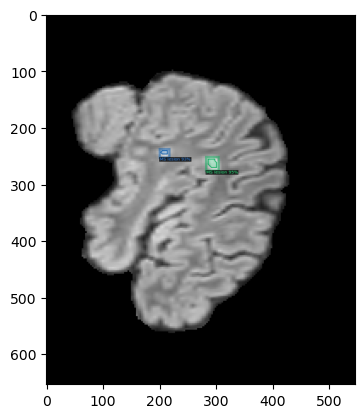

In [12]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dataset_dicts, 1):    # del conjunto de validación se realiza una prueba de inferencia
    im = cv2.imread(d["file_name"])
    print(d["file_name"])  #printear el nombre de la imagen, guardarlo y mostrar al lado la máscara correspondiente haciendo un merge quizás sobre la imagen original (?)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=3,
                   instance_mode=ColorMode.IMAGE_BW   # se pone en blanco y negro aquellos pixeles que no estén dentro de zonas segmentadas
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])

/mnt/Data1/MSLesSeg-Dataset/outputDivided_valFLAIR/P14_T4_FLAIR_slice_67.png
Imagen de validación: /mnt/Data1/MSLesSeg-Dataset/outputDivided_valFLAIR/P14_T4_FLAIR_slice_67.png
Nombre de la imagen de la máscara: P14_T4_MASK_slice_67.png
Ruta de la máscara: /mnt/Data1/MSLesSeg-Dataset/output_maskDivided_valFLAIR/P14_T4_MASK_slice_67.png


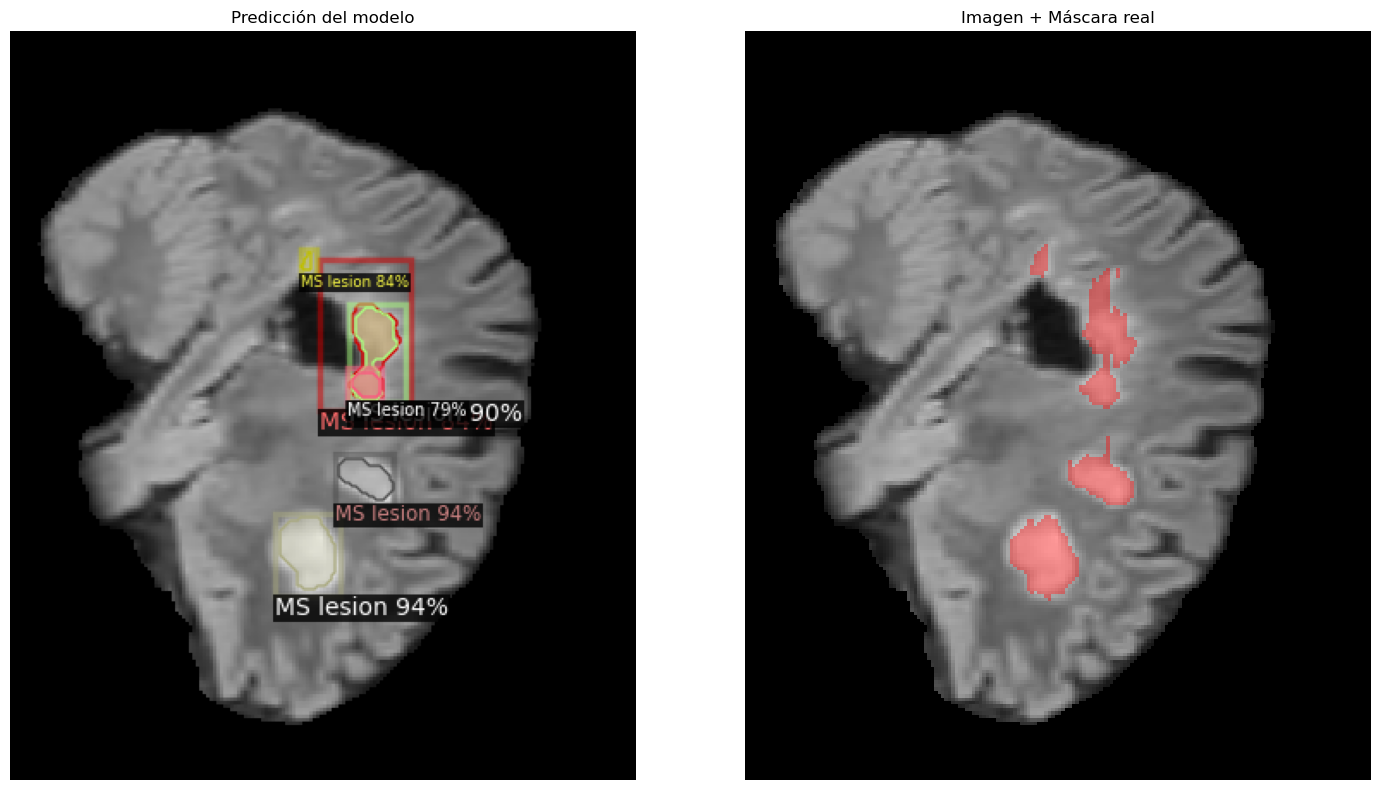

Imagen guardada en: /home/albacano/TFM-Scripts/Detectron2_models/2000epochsFLAIR/output_images/comparison_P14_T4_FLAIR_slice_67.png.png


<Figure size 640x480 with 0 Axes>

In [28]:
import cv2
import os
import random
import numpy as np
from detectron2.utils.visualizer import Visualizer, ColorMode
from matplotlib import pyplot as plt

val_mask_dir = f"{base_path_dir}/output_maskDivided_valFLAIR"
output_dir = f"{path_dir_model}/2000epochsFLAIR/output_images"
os.makedirs(output_dir, exist_ok=True)

for d in random.sample(val_dataset_dicts, 1):  # prueba con una imagen
    file_name = d["file_name"] 
    print(file_name)
    im = cv2.imread(file_name)

    print("Imagen de validación:", file_name)

    # Inferencia con el modelo
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=2,
                   instance_mode=ColorMode.IMAGE_BW)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    pred_img = out.get_image()[:, :, ::-1]
    # Cargar máscara real
    image_filename = os.path.basename("_".join(file_name.split("_")[:3]) + "_MASK_" + "_".join(file_name.split("_")[4:]))
    print("Nombre de la imagen de la máscara:", image_filename)
    mask_path = os.path.join(val_mask_dir, image_filename)
    print("Ruta de la máscara:", mask_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if mask is None:
        print(f"No se encontró la máscara para {image_filename}")
        continue

    # Convertir la imagen a blanco y negro (escala de grises)
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im_gray_3ch = cv2.cvtColor(im_gray, cv2.COLOR_GRAY2BGR)

    # Crear superposición en rojo (color de lesión) sobre la imagen en escala de grises
    mask_colored = np.zeros_like(im_gray_3ch)
    mask_colored[:, :, 2] = 255  # rojo puro

    alpha = 0.4
    overlay = np.where(mask[..., None] == 255,
                       (alpha * mask_colored + (1 - alpha) * im_gray_3ch).astype(np.uint8),
                       im_gray_3ch)

    # Mostrar lado a lado: predicción y GT
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))
    axs[0].imshow(cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Predicción del modelo")
    axs[0].axis("off")

    axs[1].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    axs[1].set_title("Imagen + Máscara real")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()
    output_path = os.path.join(output_dir, f"comparison_{os.path.basename(file_name)}.png")
    plt.savefig(output_path)
    print(f"Imagen guardada en: {output_path}")


In [30]:
import os
os.environ["DETECTRON2_USE_UNOFFICIAL_COCO_API"] = "1"

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# evaluamos las métricas del modelo con COCOEvaluator
evaluator = COCOEvaluator("my_dataset_val", output_dir=f"{path_dir_model}/2000epochsFLAIR/evaluacion/2000epochs")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[07/14 20:45:02 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[07/14 20:45:02 d2.data.datasets.coco]: Loaded 3458 images in COCO format from /mnt/Data1/MSLesSeg-Dataset/outputDivided_valFLAIR/annotations.json
[07/14 20:45:03 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
| MS lesion  | 2578         |
|            |              |
[07/14 20:45:03 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/14 20:45:03 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[07/14 20:45:03 d2.data.common]: Serializing 3458 elements to byte tensors and concatenating them all ...
[07/14 20:45:03 d2.data.common]: Serialized dataset takes 0.89 MiB
[07/14 20:45:03 d2.evaluation.evaluator]: Start inference on 3458 ba

KeyError: 'info'

In [31]:
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[07/14 21:01:40 d2.evaluation.evaluator]: Start inference on 3458 batches
[07/14 21:01:41 d2.evaluation.evaluator]: Inference done 11/3458. Dataloading: 0.0009 s/iter. Inference: 0.0690 s/iter. Eval: 0.0008 s/iter. Total: 0.0707 s/iter. ETA=0:04:03
[07/14 21:01:46 d2.evaluation.evaluator]: Inference done 83/3458. Dataloading: 0.0017 s/iter. Inference: 0.0682 s/iter. Eval: 0.0002 s/iter. Total: 0.0702 s/iter. ETA=0:03:57
[07/14 21:01:51 d2.evaluation.evaluator]: Inference done 156/3458. Dataloading: 0.0017 s/iter. Inference: 0.0676 s/iter. Eval: 0.0002 s/iter. Total: 0.0696 s/iter. ETA=0:03:49
[07/14 21:01:56 d2.evaluation.evaluator]: Inference done 229/3458. Dataloading: 0.0016 s/iter. Inference: 0.0673 s/iter. Eval: 0.0003 s/iter. Total: 0.0693 s/iter. ETA=0:03:43
[07/14 21:02:01 d2.evaluation.evaluator]: Inference done 303/3458. Dataloading: 0.0015 s/iter. Inference: 0.0671 s/iter. Eval: 0.0003 s/iter. Total: 0.0690 s/iter. ETA=0:03:37
[07/14 21:02:06 d2.evaluation.evaluator]: Infere

KeyError: 'info'

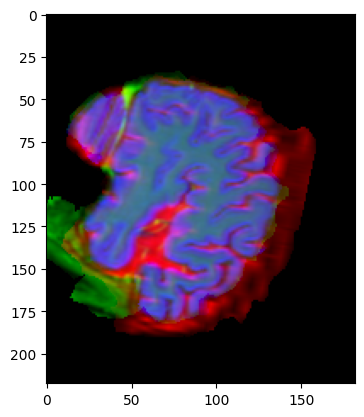

In [ ]:
# Cargamos una imagen del conjunto de test y la pasamos al predictor
new_im = cv2.imread(f"{path_dir}/testImages/P75_slice_137.png")
outputs = predictor(new_im)

# Con el objeto Visualizer nos permite mostrar por pantalla y guardar los resultados de segmentación
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image())
plt.imsave(f"{path_dir}/predictImages/P75_slice_137Detectron2-2000e.jpg", out.get_image())